# 1. Installation

Let's start with exploring different options for torch installations. There are mainly two things to consider: your operating system, and your graphic card. Torch makes available CPU-only versions and CUDA-based versions. CUDA is an API (application programming interface), a software layer for NVIDIA graphic cards that gives direct access to your GPU device and also manages numerous concepts such a parallelization and convolution algorithms. ROCm is also a similar software, but for AMD graphic cards. To train models on your GPU, you need a CUDA-based or ROC-based torch installation.

- __For Macbook owners__: Recently torch announced there will be support for Macbook chips with the new Metal Performance Shaders (MPS) backend for GPU accelaration. You can install a default version of torch, or also use Google Colab.

- __For Windows users__: You need to have an NVIDIA graphic card, compatible with the CUDA-based torch instalations of your preferred torch version. If you have an old graphic card (older than ~3-4 years), you might need to install an older version of torch (check previous versions). If you have an AMD graphic card, you can install WSL (Windows Subsystem of Linux) and pick a ROCm-based torch installation. In any case, I would highly recommend WSL which might increase your options and easier to manage.

- __For Linux or WSL users__: If you use a Linux-based system, you can either use a AMD or NVIDIA graphics card.

For installation options, Torch website is also quite explanatory:

![installation.png](./installation.png)


__Important Note__: if your PC does not have a GPU and compatible CUDA compiler installation (usually comes with NVIDIA drivers), you can run this notebook on Google Colab. It also should have its own torch installation.

As an example, this notebook is prepared on WSL and torch version 2.1.1 with CUDA 11.8. The device is NVIDIA RTX 3060 which is only compatible with CUDA versions >10. So the installation command would be (Check torch website to find the command for you):

In [ ]:
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Other packages that will be used in this notebook:

In [ ]:
! pip install matplotlib pandas numpy

In [1]:
import torch
from torch import Tensor # Only for type-annotations

Reference:

- https://pytorch.org/

- https://pytorch.org/get-started/previous-versions/

# 2. Torch Tensor objects:

In [2]:
a_tensor = torch.rand(2, 3, requires_grad=True)
a_tensor + 1

tensor([[1.1365, 1.1233, 1.8108],
        [1.9765, 1.5564, 1.1649]], grad_fn=<AddBackward0>)

Notice something different than the regular numpy arrays? Tensors used in training should be attached to gradient function (grad_fn) that is responsible for each of the backward calculations (i.e., backpropagation steps). That will be important in the training (Section 3). These gradient functions basically used to keep track of whatever happens to the tensors and that creates a tree-like structure, and this tree is called 'gradient tree'. Something that looks like this:

![gradient_tree.png](./gradient_tree.png)

Reference: https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html

__Exercise__: Create 2 tensors a and b with size [3, 5] both, where all b's are 8 and all a's are 2. You can use "number * torch.ones()" (Check torch.ones documentation for details). Then calculate the following formula: 

$$ \frac{b + \sqrt{b^2 - 4a}}{2a}$$

Track and list gradient functions step by step.

# 3. Working with GPU acceleration

Another commonly used property of the torch tensors is that you can move them between GPU and CPU memory ! Lets first check if your torch installation is ready-to-use with GPU:

In [3]:
torch.cuda.is_available() # ROCm also translated to CUDA.
# torch.backends.mps.is_available() # This line is for MAC users with MPS based torch installation.

True

If you have an error on that line, that would probably because of your torch installation is not a CUDA-supported installation. You can replace "cuda" with "backends.mps". If the above line returned True, you can also run:

In [4]:
device = torch.device("cuda")
a_tensor = torch.rand(2, 3, requires_grad=True, device=device)
a_tensor

tensor([[0.5236, 0.5454, 0.7520],
        [0.4329, 0.9686, 0.4871]], device='cuda:0', requires_grad=True)

Above we created a tensor directly in your GPU memory. But also, we can move it to CPU memory (i.e., RAM) and again back to GPU:

In [5]:
a_tensor = a_tensor.cpu()
print(a_tensor)
b_tensor = a_tensor.to(device)
print(b_tensor)

tensor([[0.5236, 0.5454, 0.7520],
        [0.4329, 0.9686, 0.4871]], grad_fn=<ToCopyBackward0>)
tensor([[0.5236, 0.5454, 0.7520],
        [0.4329, 0.9686, 0.4871]], device='cuda:0', grad_fn=<ToCopyBackward0>)


__Exercise__: Create two tensors: x_tensor and y_tensor with size [100,1000] both. Allocate x_tensor on GPU, and y_tensor on CPU. Then calculate this: 

$$ \frac{x^2}{2x}$$

 for both tensors separately and report execution times.

In [19]:
# You can use %timeit for whole operation to measure time.
%timeit

8.4 µs ± 534 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [20]:
# Better to use %timeit in separate cells.
%timeit

11.9 µs ± 523 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


__Note__: GPU accelaration is usually more effective on backpropagation.

# 4. Torch Dataset class

Dataset class is the backbone of the data operations of any kind. Usually it is a good idea to create your own dataset class to have dataset-specific functionalities. Such as preprocessing, augmentations, IO-operations, tensor shaping...

In [6]:
import os
from torch.utils.data import Dataset
from torchvision.io import read_image
import pandas as pd

# Built-in Dataset class should be inherited from your custom datasets.
class PokemonDataset(Dataset):
    def __init__(self, path_to_data: str) -> None:
        # Initialize the inherited class with super().
        super().__init__()

        self.path_to_data = path_to_data
        self.images_list = os.listdir(os.path.join(self.path_to_data, "images"))
        self.metadata = pd.read_csv(os.path.join(self.path_to_data, "pokemon.csv"))
        # Create label encoding for the text labels to make them machine-understandable.
        self.metadata["label_code"] = pd.Categorical(self.metadata["Type1"]).codes

    def __getitem__(self, idx: Tensor) -> Tensor:
        """Compulsory for iteration."""
        # Get the next image file name from the list.
        image_name = self.images_list[idx]
        # Create the path to image.
        path_to_image = os.path.join(self.path_to_data, "images", image_name)
        # Read image to a torch tensor. Since we are creating a new tensor here, we should move it to our preferred device.
        image = read_image(path_to_image).to(device)
        # Apply transformations.
        transformed_image = self.augmentation(self.preprocessing(image))
        # Pokemon name is the file name but without the extension .png, .jpg etc.
        pokemon_name = image_name.split(".")[0]
        # Find the pokemon from the csv and get its label code.
        label = self.metadata[self.metadata["Name"] == pokemon_name]["label_code"].to_numpy()
        # Return. Since we are creating a tensor here (torch.from_numpy), we should move it to our preferred device.
        return transformed_image, torch.from_numpy(label).to(device).squeeze()
    
    def __len__(self) -> int:
        """Compulsory for iteration."""
        return len(self.images_list)
    
    # You can create other functions to simplify your code (__getitem__ function), such as get_label() or get_image() etc.
    
    def preprocessing(self, img: Tensor) -> Tensor:
        # Optional
        return img
    
    def augmentation(self, img: Tensor) -> Tensor:
        # Optional
        return img

Reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

# 5. Torch Dataloaders

In [7]:
from torch.utils.data import DataLoader

Dataloader is a class that helps to iterate over your dataset, handles batching, data parallelization and various other functionalities. It has a default way to create batches, but needs an input Dataset class to iterate over.

Collating is a term that its functionality collects multiple samples (and its labels) to a batch and defines the batch-level Dataloader behaviour. Basically you can create a function that accepts batch_data (list of whatever is returned from __getitem function of your Dataset class). In this example, it is list of tuple of 2 tensors, these Tensors are the ones returned as (images, labels) from the __getitem function above. And the list of these actually multiple samples that you should create the batch from. Length of this list should be equal to your BATCH_SIZE. Collate function is usually provide more flexibility, especially when we need batches with different size each.

In [8]:
from torch.utils.data import default_collate
from typing import List, Tuple # for type-annotations

def my_batch_collate(batch_data: List[Tuple[Tensor, Tensor]]) -> Tensor:
    return batch_data

In [9]:
BATCH_SIZE = 5
PATH_TO_DATA = "../sample_data/"

tr_dataset = PokemonDataset(PATH_TO_DATA)
tr_dataloader = DataLoader(
    tr_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=default_collate,
)

Reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

This configuration should create a tensor of images in the following shape: [5, 4, 120, 120] which represents [batch_size, n_channels, img_height, img_width]. Note that RGB images have 3-channels, RGBA 4-channels and grayscale only one channel. Real data is usually very messy, thats why you will probably get errors most of the time.

Lets try out how the data is iterated !

torch.Size([5, 4, 120, 120])
torch.Size([5])


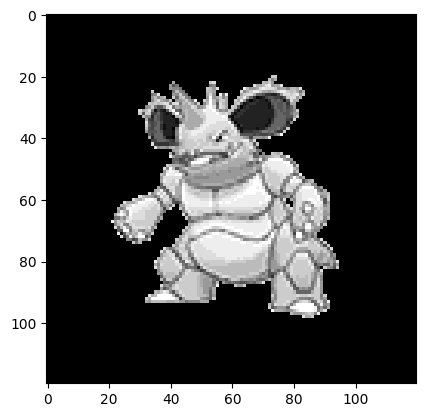

RuntimeError: stack expects each tensor to be equal size, but got [4, 120, 120] at entry 0 and [3, 120, 120] at entry 2

In [10]:
import matplotlib.pyplot as plt

for image, label in tr_dataloader:
    print(image.shape)
    print(label.shape)

    # Plot first image in the batch as grayscale (first channel).
    # Note that we need to detach the gradients and move back to CPU to convert tensors to numpy !
    plt.imshow(image.detach().cpu().numpy()[0, 0], cmap="gray")
    plt.show()

__Exercise__: As you have noticed, you cannot create a batch if there are images in the same batch with different color coding. You can handle this situation by padding for RGB and grayscale images to 4-channels, or you can also pick only one channel. This is a good example why we should use our own batch collation function for dataloading, or you can change this in Dataset class as well (suitable case for preprocessing function.).

__HINT__: Its easier when you use the torch functions: torch.stack() and torch.tensor.expand(). Check documentation for details.

In [11]:

def img_channel_padding_collate(batch_data: List[Tuple[Tensor, Tensor]]) -> Tuple[Tensor, Tensor]:
    # batch_data is a list of inputs returned from __getitem__ function of the Dataset class.
    # Here you need to create one single tensor with size [batch_size, n_channels=4, img_height, img_width].

    # Handle the situation here:
    for img, label in batch_data:
        print(img.shape, label)
        
    return # Return 2 tensors: batched_images, batched_labels

In [12]:
# Define the dataloader and attach your collate function.
tr_dataloader = DataLoader(
    tr_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=img_channel_padding_collate,
)

In [13]:
# Try to run the iteration again:
for image, label in tr_dataloader:
    print(image.shape)
    print(label.shape)

torch.Size([4, 120, 120]) tensor(13, device='cuda:0', dtype=torch.int8)
torch.Size([4, 120, 120]) tensor(16, device='cuda:0', dtype=torch.int8)
torch.Size([4, 120, 120]) tensor(3, device='cuda:0', dtype=torch.int8)
torch.Size([4, 120, 120]) tensor(0, device='cuda:0', dtype=torch.int8)
torch.Size([4, 120, 120]) tensor(8, device='cuda:0', dtype=torch.int8)


TypeError: cannot unpack non-iterable NoneType object